In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
np.random.seed(0)

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

import scikitplot as skplt
from scikitplot.estimators import plot_learning_curve

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score, f1_score

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

import xgboost as xgb
import lightgbm as lgb
import catboost as ctb
    
from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

import matplotlib.pyplot as plt
import scikitplot as skplt
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

In [14]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68361 entries, 0 to 22666
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   breadcrumbs                 68361 non-null  object 
 1   date                        68361 non-null  object 
 2   geo_block                   68361 non-null  object 
 3   owner                       68361 non-null  object 
 4   price                       45694 non-null  float64
 5   Security:                   39116 non-null  object 
 6   Building type:              68106 non-null  object 
 7   Object type:                68349 non-null  object 
 8   Ad type:                    68349 non-null  object 
 9   Commission agent:           67876 non-null  object 
 10  Construction phase:         53482 non-null  object 
 11  Housing class:              53482 non-null  object 
 12  Elevator:                   40036 non-null  object 
 13  Bathroom type:              184

In [2]:
import gc

train = pd.read_hdf('../input/property.train.h5')
test = pd.read_hdf('../input/property.test.h5')

df_all = pd.concat([train, test], sort = False)

#Reduce street names
def filter_string(s):
    if s != np.nan:
        s = str(s)
        return re.sub(r'^.*?\.|ул', '', s).strip()
    else:
        return s

#Clean geo_block column
def clean_bread_geo(l):
    new_l = []
    for i in l:
        new_l.append(filter_string(i))
    new_l = list(dict.fromkeys(new_l))
    return new_l

#Keep only unique from breadcrumbs
def strip_bread_from_geo(r):
    r['breadcrumbs_clean'] = tuple([x for x in r['breadcrumbs_clean'] if x not in r['geo_block_clean']])
    return r

#Get subway
def get_mlik(l):
    for i in l:
        new_l = i.split()
        if 'МЦК' in new_l:
            return i
    return np.nan

#Remove subway from breadcrumbs
def remove_mlik(l):
    blacklist = ['МЦК']
    vals_to_rem = []
    for i in l:
        new_l = i.split()
        for j in new_l:
            if j in blacklist:
                vals_to_rem.append(i)
                break
    return [x for x in l if x not in vals_to_rem]

#Extract year from date
def get_year(l):
    date = l[0].split()
    for x in date:
        if x in ('2014','2015','2016','2017','2018','2013'):
            return x
    return np.nan

def is_new_moscow(l):
    return 'yes' if 'Новая Москва' in l else np.nan

#Get security features from Security:
def get_from_security(x, word):
    split_x = x.replace(',', ' ').split()
    for i in split_x:
        if i.lower() in word:
            return True
    return False

#Append kitchen furniture
def get_kitchen(r):
    l = []
    if r['Fridge:'] == 'yes':
        l.append('fridge')
    #if r['Washing machine:'] == 'yes':
        #l.append('washing_machine')
    if r['Kitchen furniture:'] == 'yes':
        l.append('furniture')
    r['Kitchen furniture:'] = tuple(l)
    return r
    
df_all['breadcrumbs_clean'] = df_all['breadcrumbs'].map(clean_bread_geo)
df_all['geo_block_clean'] = df_all['geo_block'].map(lambda x : tuple(clean_bread_geo(x)))

df_all['breadcrumbs_clean'] = df_all['breadcrumbs_clean'].map(remove_mlik)

df_all = df_all.apply(strip_bread_from_geo, axis=1)

df_all['subway'] = df_all['breadcrumbs'].map(get_mlik) 

df_all['date_clean'] = df_all.date.map(get_year)

df_all['owner_clean'] = df_all.owner.map(lambda x: ''.join(x) if x else str(-1))

df_all['new_moscow'] = df_all['geo_block_clean'].map(is_new_moscow)

df_all['parking'] = df_all['Security:'].map(lambda x : 'yes' if get_from_security(str(x), ['parking']) == True else np.nan)

df_all = df_all.apply(get_kitchen, axis=1)

df_all['Construction phase:'] = np.where(df_all['Construction phase:'] == 'Playground', 'Finish', df_all['Construction phase:'])

In [ ]:
#Find security feats for given keywords
potentail_sec = ['yes', 'provided', 'is', 'barrier', 'fenced', 'closed', 'area', 'territory', 'protected', 'access', 'allowed',
         'alarm', 'fire', 'system', 'intercom', 'ip-intercom', 'concierge', 'video', 'surveillance', 'cctv', 'cameras', 'camera',
         'security', 'guarded', 'round-the-clock', '24-hour']
df_all['has_security'] = df_all['Security:'].map(lambda x : 'yes' if get_from_security(str(x), potentail_sec) == True else np.nan)
df_all['concierge'] = df_all['Security:'].map(lambda x : 'yes' if get_from_security(str(x), ['concierge']) == True else np.nan)
guards_l = ['security', 'guarded', 'round-the-clock', '24-hour']
df_all['guards'] = df_all['Security:'].map(lambda x : 'yes' if get_from_security(str(x), guards_l) == True else np.nan)
cctv_l = ['video', 'surveillance', 'cctv', 'cameras', 'camera']
df_all['cctv'] = df_all['Security:'].map(lambda x : 'yes' if get_from_security(str(x), cctv_l) == True else np.nan)
fence_l = ['barrier', 'fenced', 'closed', 'area', 'territory', 'protected']
df_all['fenced'] = df_all['Security:'].map(lambda x : 'yes' if get_from_security(str(x), fence_l) == True else np.nan)

In [3]:
#This block of code finds a mean price for all given streets and then marks that street as expensive 
#if the street's mean price is greater than the mean price of all streets 
street_dict = {}
df_all['price'] = np.where(df_all['price'].isnull(), -1, df_all['price'])
def get_street(r):
    for x in r['geo_block_clean']:
        if x not in ['Новая Москва', 'Москва']:
            if x in street_dict:
                street_dict[x].append(r['price'])
            else:
                street_dict[x] = [r['price']]
                
df_all.apply(get_street, axis=1);

nan_vals = {}
for key, value in street_dict.items():
    l = list(filter(lambda x: x != -1, value))
    if l:
        nan_vals[key] = np.mean(l)

df_all['price'] = np.where(df_all['price'] == -1, np.nan, df_all['price'])

df_all['mean'] = df_all['price'].map(lambda x : -1)

def set_mean(r):
    for x in r['geo_block_clean']:
        if x in nan_vals:
            if nan_vals[x] > 11:
                r['mean'] = 'yes'
    return r

df_all = df_all.apply(set_mean, axis=1)

In [4]:
cat_feats = df_all.select_dtypes(include=[object]).columns

delete_values = ['breadcrumbs', 'date', 'geo_block', 'owner']

for x in delete_values:
    cat_feats = np.delete(cat_feats, np.where(cat_feats == x))

for cat_feat in cat_feats:
    df_all['{0}_cat'.format(cat_feat.lower()).replace(':', '').replace(' ', '_')] = pd.factorize( df_all[cat_feat], na_sentinel = -1)[0]

train = df_all[df_all['price'].notnull()]
test = df_all[df_all['price'].isnull()]

test1 = pd.read_hdf('../input/property.test.h5')

test['id'] = test1['id']

del df_all, test1
gc.collect()

del test['price']

train.drop([41594, 27304], inplace=True) #remove outliners

<ipython-input-4-bced7f4aff75>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['id'] = test1['id']


In [5]:
feats_rem = [
    'id',
    'price',
    'fridge_cat',
    #'concierge_cat',
    #'cctv_cat',
    #'has_security_cat',
    #'guards_cat',
    #'fenced_cat',
    'security_cat'
    #'washing_machine_cat'
]

feats = train.select_dtypes(include=[int]).columns.values

for x in feats_rem:
    feats = np.delete(feats, np.where(feats == x))

X = train[ feats ].values
y = train['price'].values

feats

array(['building_type_cat', 'object_type_cat', 'ad_type_cat',
       'commission_agent_cat', 'construction_phase_cat',
       'housing_class_cat', 'elevator_cat', 'bathroom_type_cat',
       'balcony_type_cat', 'mortgage_possible_cat',
       'the_view_from_the_window_cat', 'garbage_chute_cat', 'repair_cat',
       'phone_cat', 'furniture_cat', 'free_layout_cat',
       'it_is_possible_to_bargain_cat', 'floor_covering_cat',
       'room_type_cat', 'internet_cat', 'kitchen_furniture_cat', 'tv_cat',
       'washing_machine_cat', 'foundation_type_cat', 'overlap_type_cat',
       'type_of_the_building_cat', 'playground_cat', 'class_cat',
       'breadcrumbs_clean_cat', 'geo_block_clean_cat', 'subway_cat',
       'date_clean_cat', 'owner_clean_cat', 'new_moscow_cat',
       'parking_cat', 'has_security_cat', 'concierge_cat', 'guards_cat',
       'cctv_cat', 'fenced_cat', 'mean_cat'], dtype=object)

In [6]:
def huber_approx_obj(y_true, y_pred):
    z = y_pred - y_true
    delta = 1.35
    scale = 1.3 + (z/delta)**2
    scale_sqrt = np.sqrt(scale)
    grad = z/scale_sqrt
    hess = 10.3/(scale*scale_sqrt)
    return grad, hess

xgb_params = {
        'max_depth': 8,
        'colsample_bytree': 0.8021935159972803,
        'learning_rate': 0.0859245491522357,
        'subsample': 0.8973229799732887,
       'random_state': 6700,
        'min_child_weight': 2.0,
        'reg_alpha': 1.3799196091897554,
        'reg_lambda': 0.9862968829200137,
        'n_estimators': 500,
        'gamma' : 0.1,
        'objective': huber_approx_obj,
        'eval_metric': 'mae'
}

model = xgb.XGBRegressor(**xgb_params)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2018)

In [7]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test) 
y_pred = np.where(y_pred<0, -y_pred, y_pred)
mean_absolute_error(y_test, y_pred)

5.165232051493266

In [ ]:
#Feature Importance

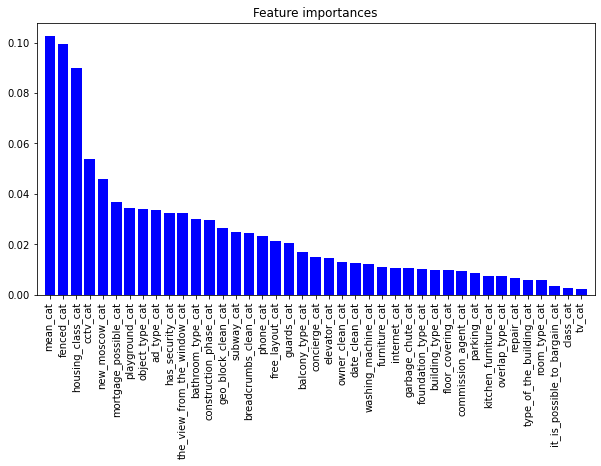

In [8]:
def draw_feature_importances(model, features):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 5))
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), model.feature_importances_[indices],
           color="b", align="center")
    plt.xticks(range(X.shape[1]), [ features[x] for x in indices])
    plt.xticks(rotation=90)
    plt.xlim([-1, X.shape[1]])
    plt.show()
    
draw_feature_importances(model, feats)

In [9]:
#Heatmap corr

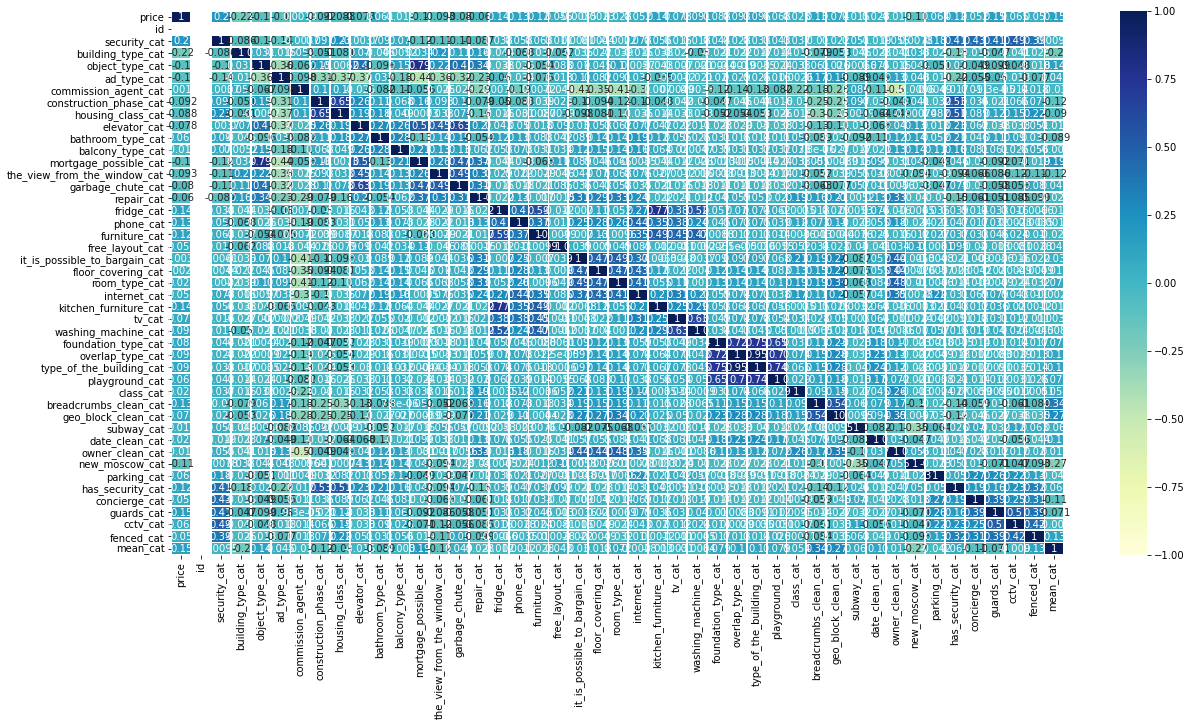

In [10]:
plt.rcParams['figure.figsize']=(20,10)
sns.heatmap(train.corr(), vmax=1., vmin=-1., annot=True, linewidths=.8, cmap="YlGnBu");

In [11]:
#Learning curve

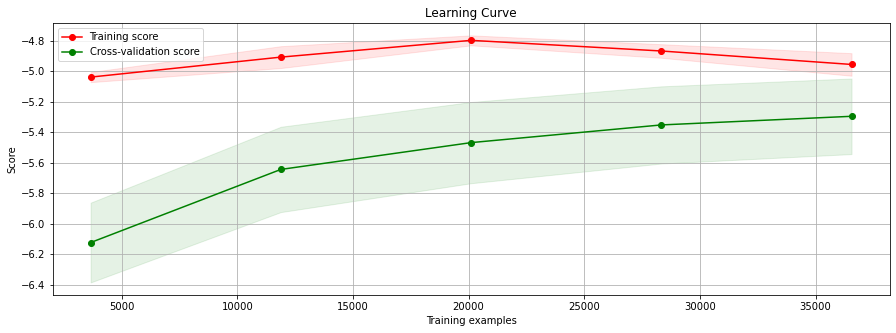

In [12]:
skplt.estimators.plot_learning_curve(model, X, y, figsize=(15, 5), cv=5, scoring='neg_mean_absolute_error');

In [13]:
#Hyperopt

In [ ]:
def objective(space):
    
    xgb_params = {
        'max_depth': 17,
        'colsample_bytree': 0.8021935159972803,
        'learning_rate': 0.0859245491522357,
        'subsample': 0.8868609961215616,
        'random_state': 6700,
        'min_child_weight': 2.0,
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'n_estimators': 1700,
        'objective': huber_approx_obj
    }
    
    print(space)
    
    model = xgb.XGBRegressor(**xgb_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    score = mean_absolute_error(y_test, y_pred)
    print(score)
    return{'loss':score, 'status': STATUS_OK }
    
space ={
    #'max_depth': hp.choice("max_depth", np.arange(10,20,1)),
    #'n_estimators':hp.quniform('n_estimators',300,2000,1),
    #'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.8, 1.),
    #'learning_rate': hp.uniform ('x_learning_rate', 0.05, 0.2),
    #'subsample': hp.uniform ('x_subsample', 0.7, 1.),
    #'random_state': hp.quniform ('x_random_state', 0, 10000, 50),
    #'min_child_weight': hp.quniform ('x_min_child_weight', 1, 10, 1),
    'reg_alpha': hp.loguniform ('x_reg_alpha', 0., 1.2),
    'reg_lambda': hp.uniform ('x_reg_lambda', 0.8, 1.),
}


trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=20),
            max_evals=50,
            trials=trials)

print("The best params: ", best_params)